In [3]:
import os
import re
import json
import matplotlib.pyplot as plt
from datetime import datetime

def extract_experiment_name_from_filename(filename):
    pattern = r'(unet_resnet50|medsam_vit_b)_(\w+)_lr([\d\.]+)_bs(\d+)_(\w+)_(\d+\.?\d*)pct_(\d+)'
    match = re.search(pattern, filename)
    if match:
        model = match.group(1)
        opt = match.group(2)
        lr = match.group(3)
        bs = match.group(4)
        loss = match.group(5)
        ts = match.group(6)
        dt = match.group(7)
        return f"{model}_{opt}_lr{lr}_bs{bs}_{loss}_{ts}pct_{dt}"
    return None

def filter_outliers(values, threshold=0.6):
    return [v if v <= threshold else None for v in values]

def load_metrics_from_directory(directory, threshold=0.6):
    results = {}
    for fname in os.listdir(directory):
        if fname.endswith("_metrics.json"):
            full_path = os.path.join(directory, fname)
            experiment_name = extract_experiment_name_from_filename(fname)
            if experiment_name is None:
                continue
            with open(full_path, "r") as f:
                data = json.load(f)
            train_losses = filter_outliers(data["train_losses"], threshold)
            val_losses = filter_outliers(data["val_losses"], threshold)
            try:
                val_dices = data["val_dices"]
            except:
                continue
            results[experiment_name] = (train_losses, val_losses, val_dices)
    return results

def ewma(data, weight):
    """Exponentially Weighted Moving Average of the values in `data`.
    
    Parameters:
        data: list containing a time-series
        weight: value in the range [0, 1)
    Returns:
        Smoothed data
    """

    last = 0
    smoothed = []
    num_acc = 0
    for next_val in data:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - weight**num_acc
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

def plot_metric(metrics, title, ylabel, out_png=None):
    plt.figure(figsize=(16, 12))
    
    for experiment_name, values in sorted(metrics.items()):
        e_a = []
        v_a = []
        epochs = range(1, len(values) + 1)
        for e, v in zip(epochs, values):
            if v is not None:
                e_a.append(e)
                v_a.append(v)
        v_a = ewma(v_a, 0.75)
        plt.plot(e_a, v_a, label=f"{experiment_name}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.grid(True)
    if out_png:
        plt.savefig(out_png, bbox_inches="tight")
    plt.show()

In [4]:
medsam_metrics_dir = "/home/fonta42/Desktop/masters-degree/experiments/med-sam/metrics"
unet_metrics_dir = "/home/fonta42/Desktop/masters-degree/experiments/u-net/metrics"

medsam_data = load_metrics_from_directory(medsam_metrics_dir)
unet_data = load_metrics_from_directory(unet_metrics_dir)

current_date = datetime.now()
formatted_date = current_date.strftime("%d_%m_%Y")

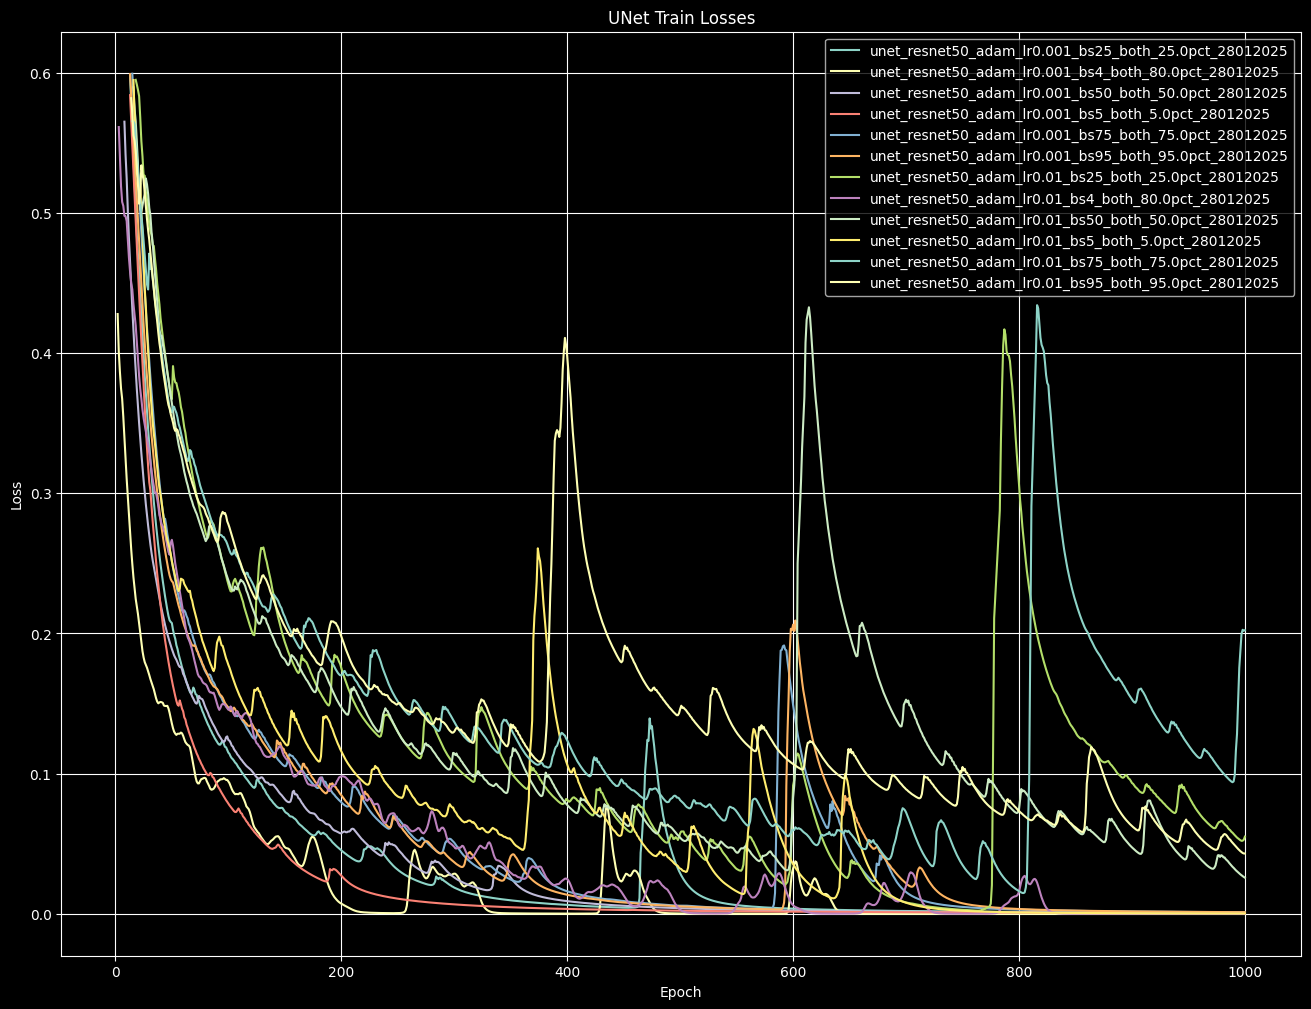

In [5]:
unet_train_losses = {ts: values[0] for ts, values in unet_data.items()}
plot_metric(unet_train_losses, "UNet Train Losses", "Loss", out_png=f"./metrics_overview/unet_train_losses_{formatted_date}.png")

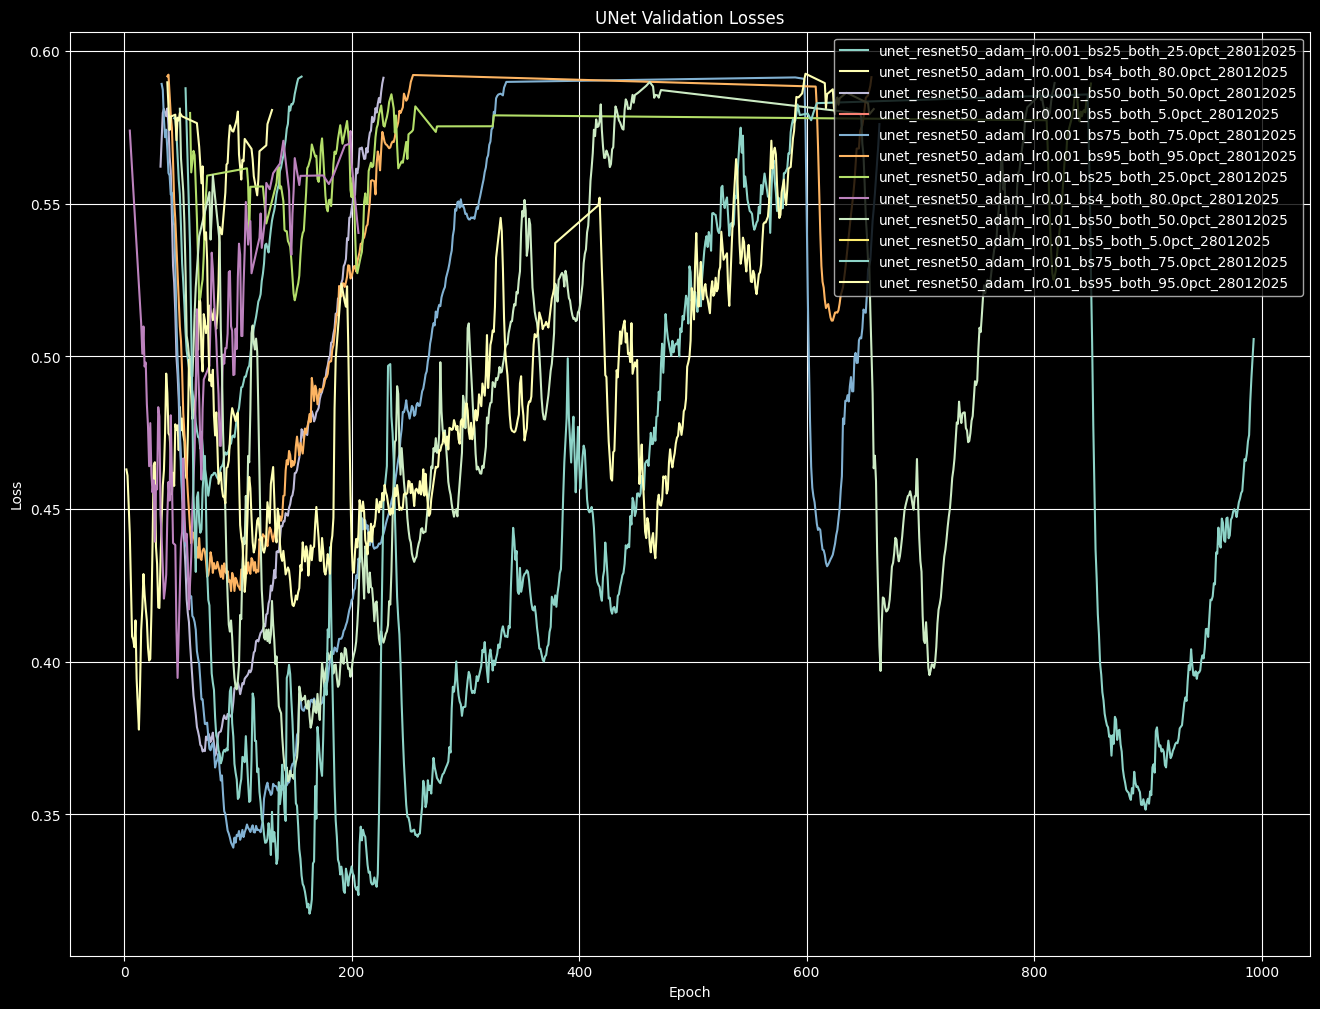

In [6]:
unet_val_losses = {ts: values[1] for ts, values in unet_data.items()}
plot_metric(unet_val_losses, "UNet Validation Losses", "Loss", out_png=f"./metrics_overview/unet_val_losses{formatted_date}.png")

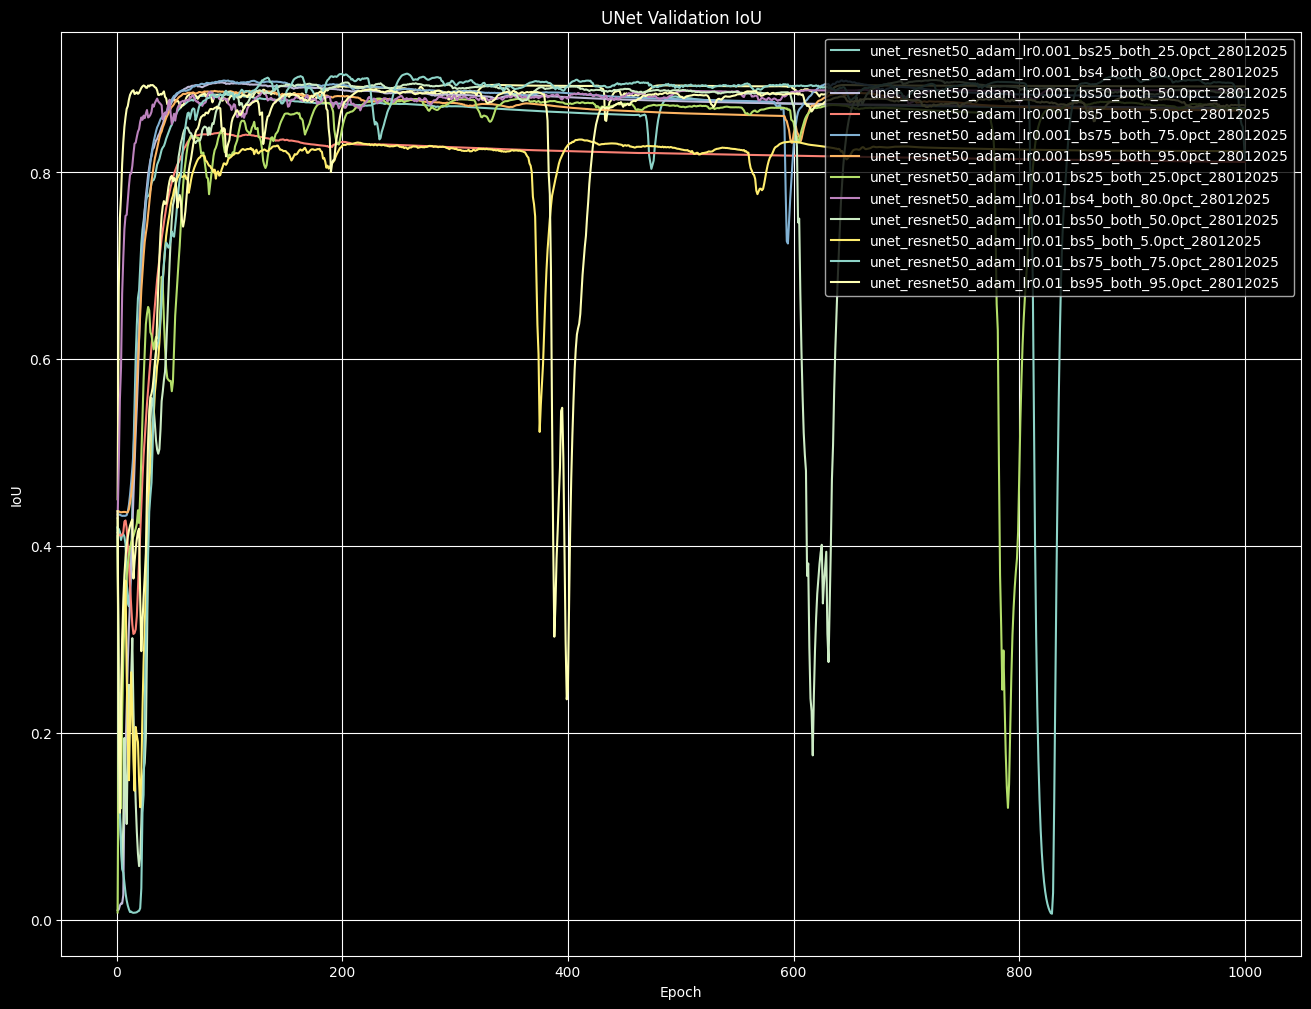

In [7]:
unet_val_dice = {ts: values[2] for ts, values in unet_data.items()}
plot_metric(unet_val_dice, "UNet Validation dice", "dice", out_png=f"./metrics_overview/unet_val_dice{formatted_date}.png")

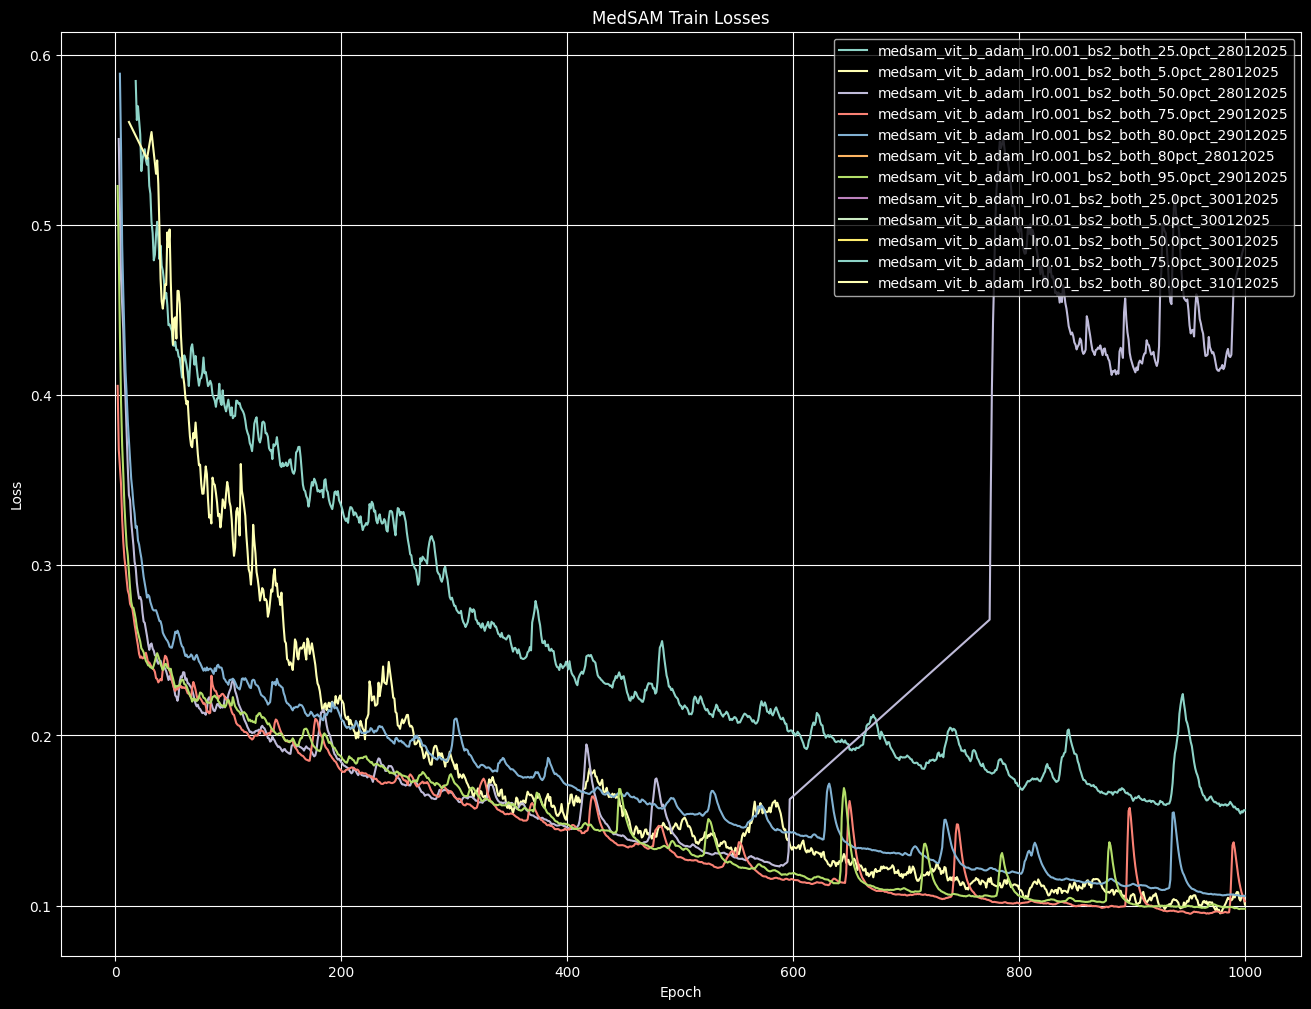

In [8]:
medsam_train_losses = {ts: values[0] for ts, values in medsam_data.items()}
plot_metric(medsam_train_losses, "MedSAM Train Losses", "Loss", out_png=f"./metrics_overview/medsam_train_losses{formatted_date}.png")

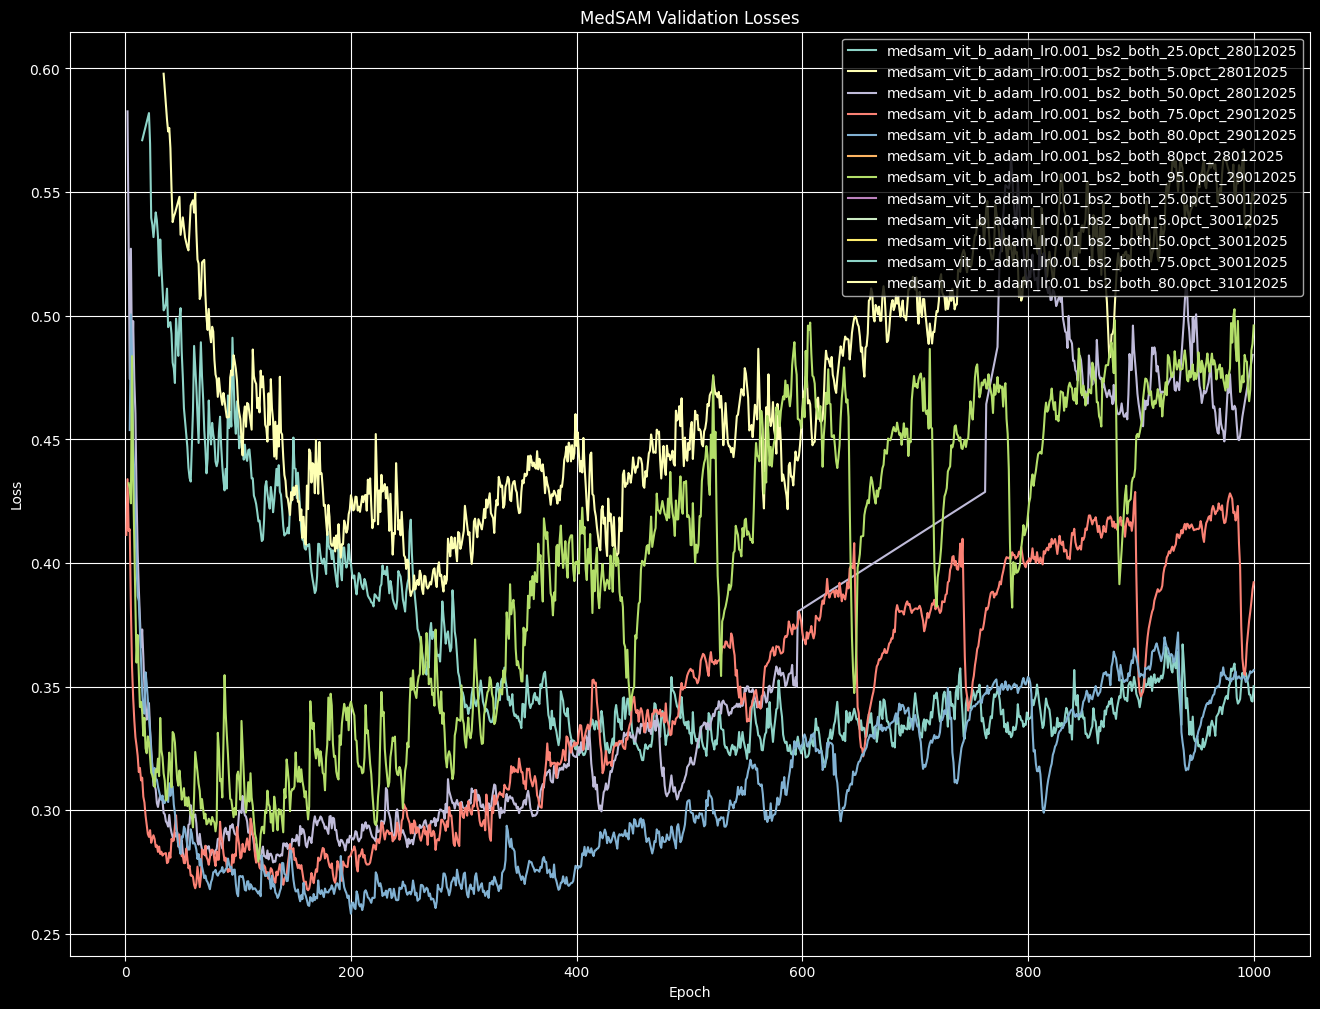

In [9]:
medsam_val_losses = {ts: values[1] for ts, values in medsam_data.items()}
plot_metric(medsam_val_losses, "MedSAM Validation Losses", "Loss", out_png=f"./metrics_overview/medsam_val_losses{formatted_date}.png")

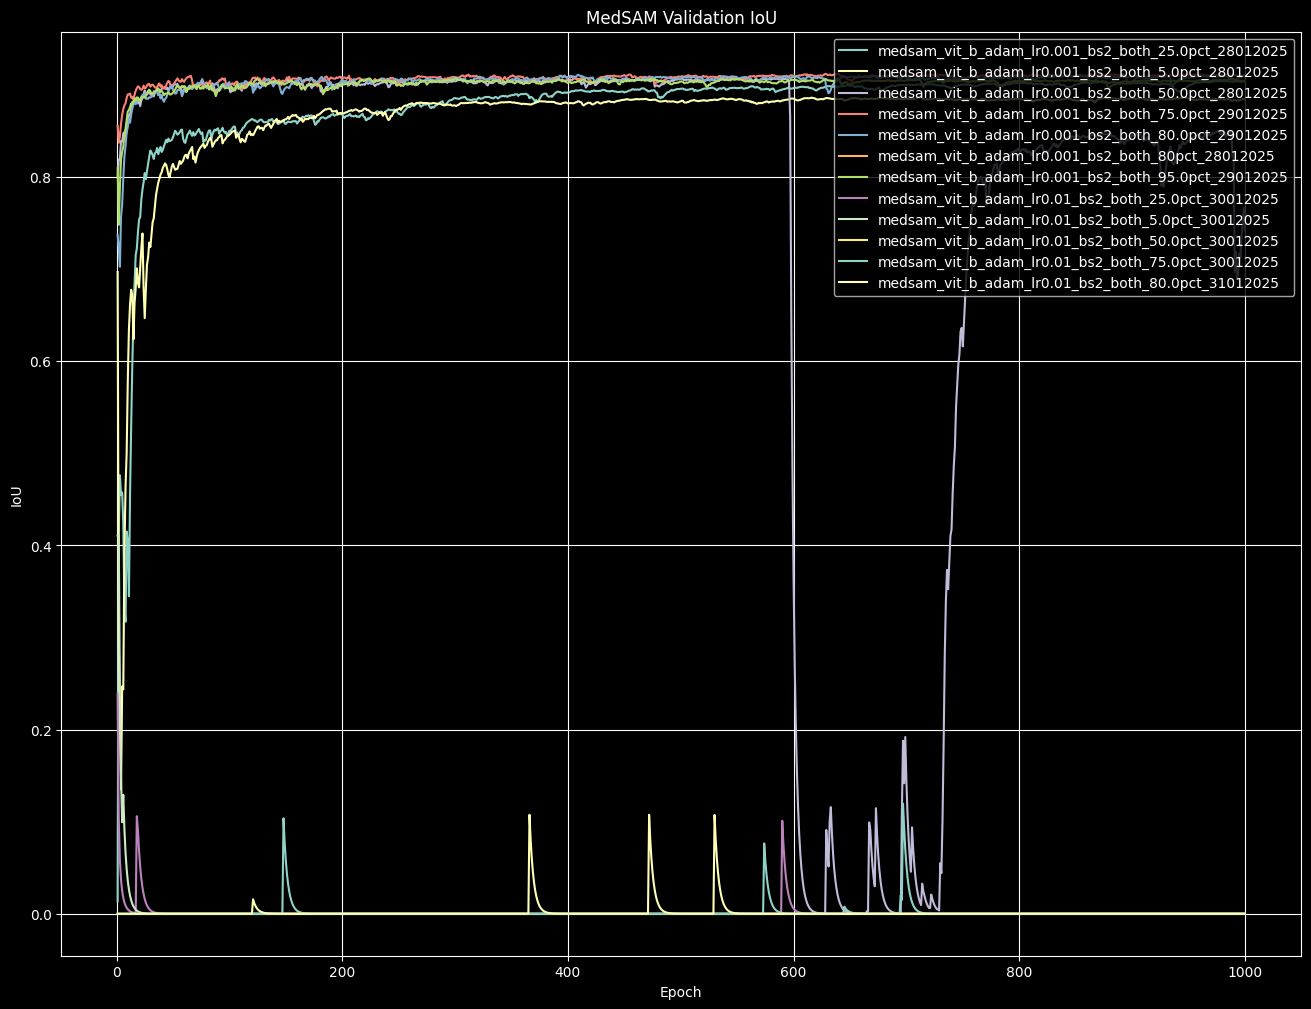

In [ ]:
medsam_val_dice = {ts: values[2] for ts, values in medsam_data.items()}
plot_metric(medsam_val_dice, "MedSAM Validation dice", "dice", out_png=f"./metrics_overview/medsam_val_dice{formatted_date}.png")

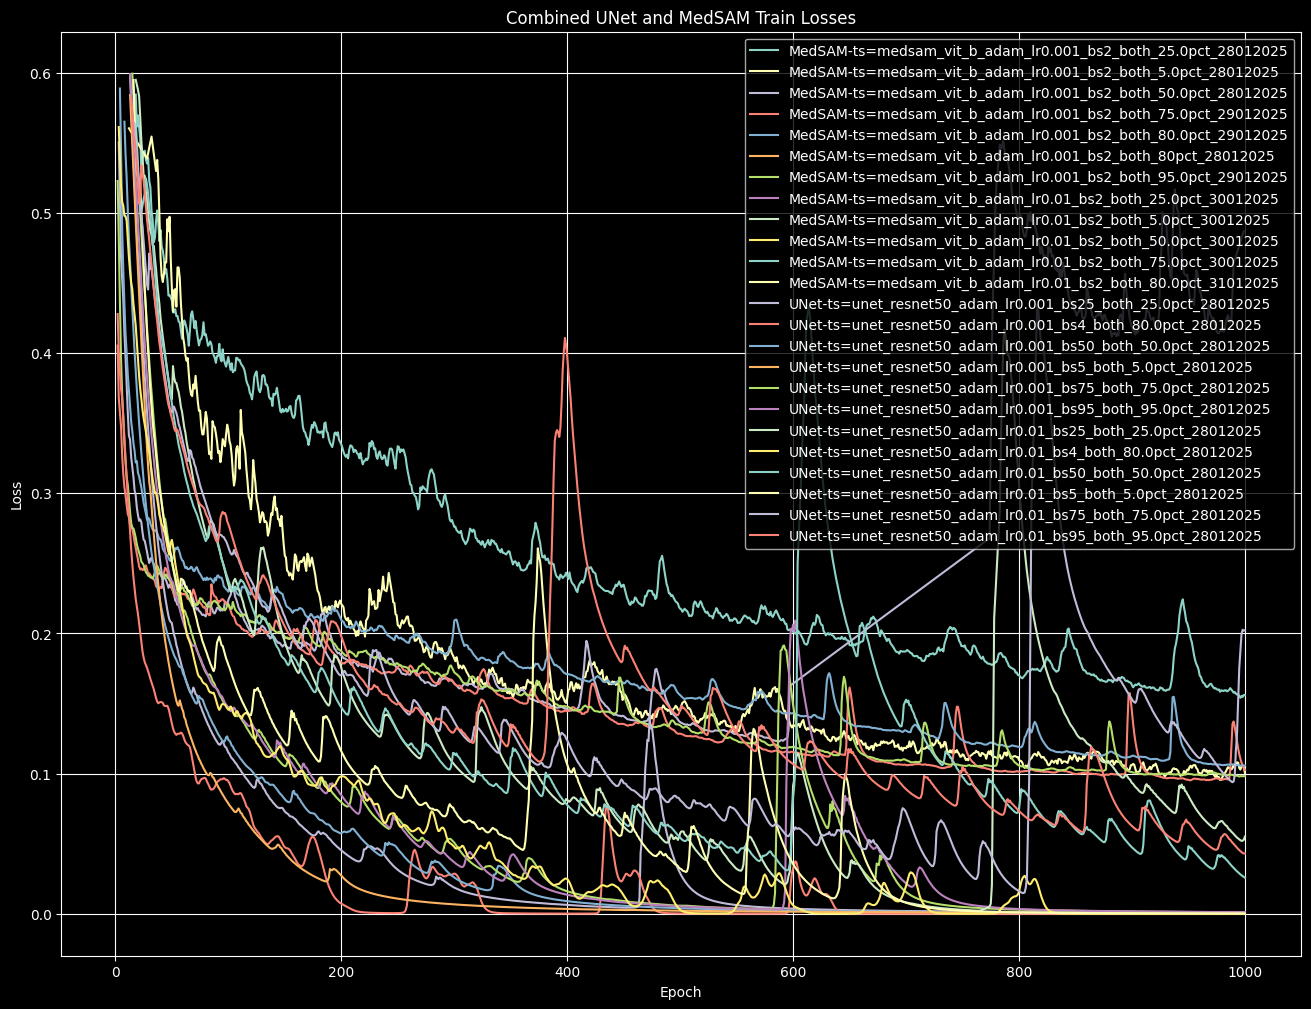

In [11]:
combined_train_losses = {f"UNet-ts={ts}": values[0] for ts, values in unet_data.items()}
combined_train_losses.update({f"MedSAM-ts={ts}": values[0] for ts, values in medsam_data.items()})
plot_metric(combined_train_losses, "Combined UNet and MedSAM Train Losses", "Loss", out_png=f"./metrics_overview/combined_train_losses{formatted_date}.png")

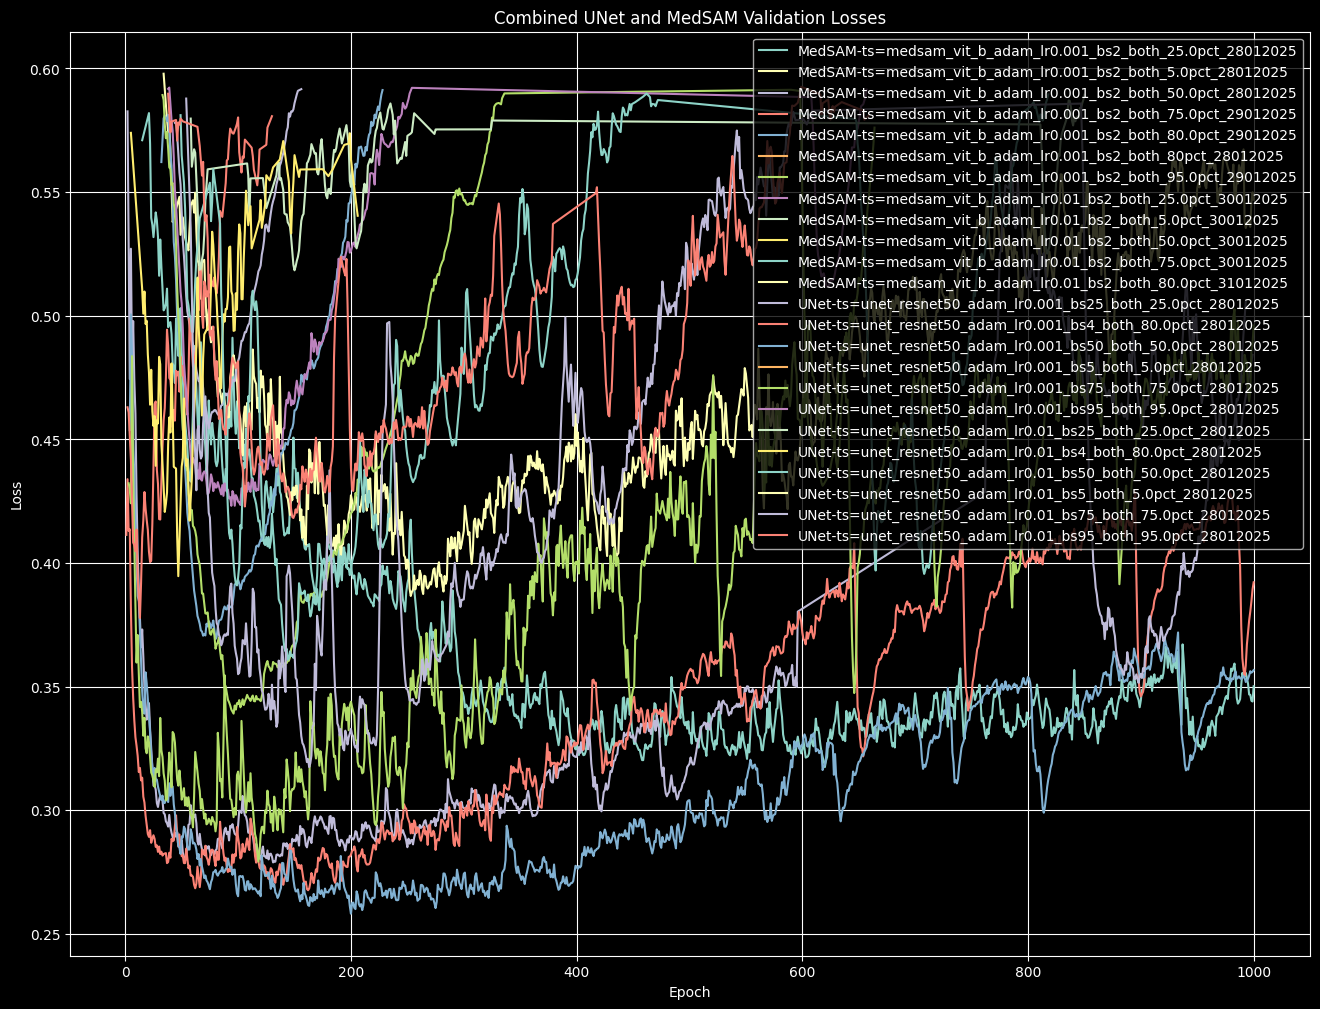

In [12]:
combined_val_losses = {f"UNet-ts={ts}": values[1] for ts, values in unet_data.items()}
combined_val_losses.update({f"MedSAM-ts={ts}": values[1] for ts, values in medsam_data.items()})
plot_metric(combined_val_losses, "Combined UNet and MedSAM Validation Losses", "Loss", out_png=f"./metrics_overview/combined_val_losses{formatted_date}.png")

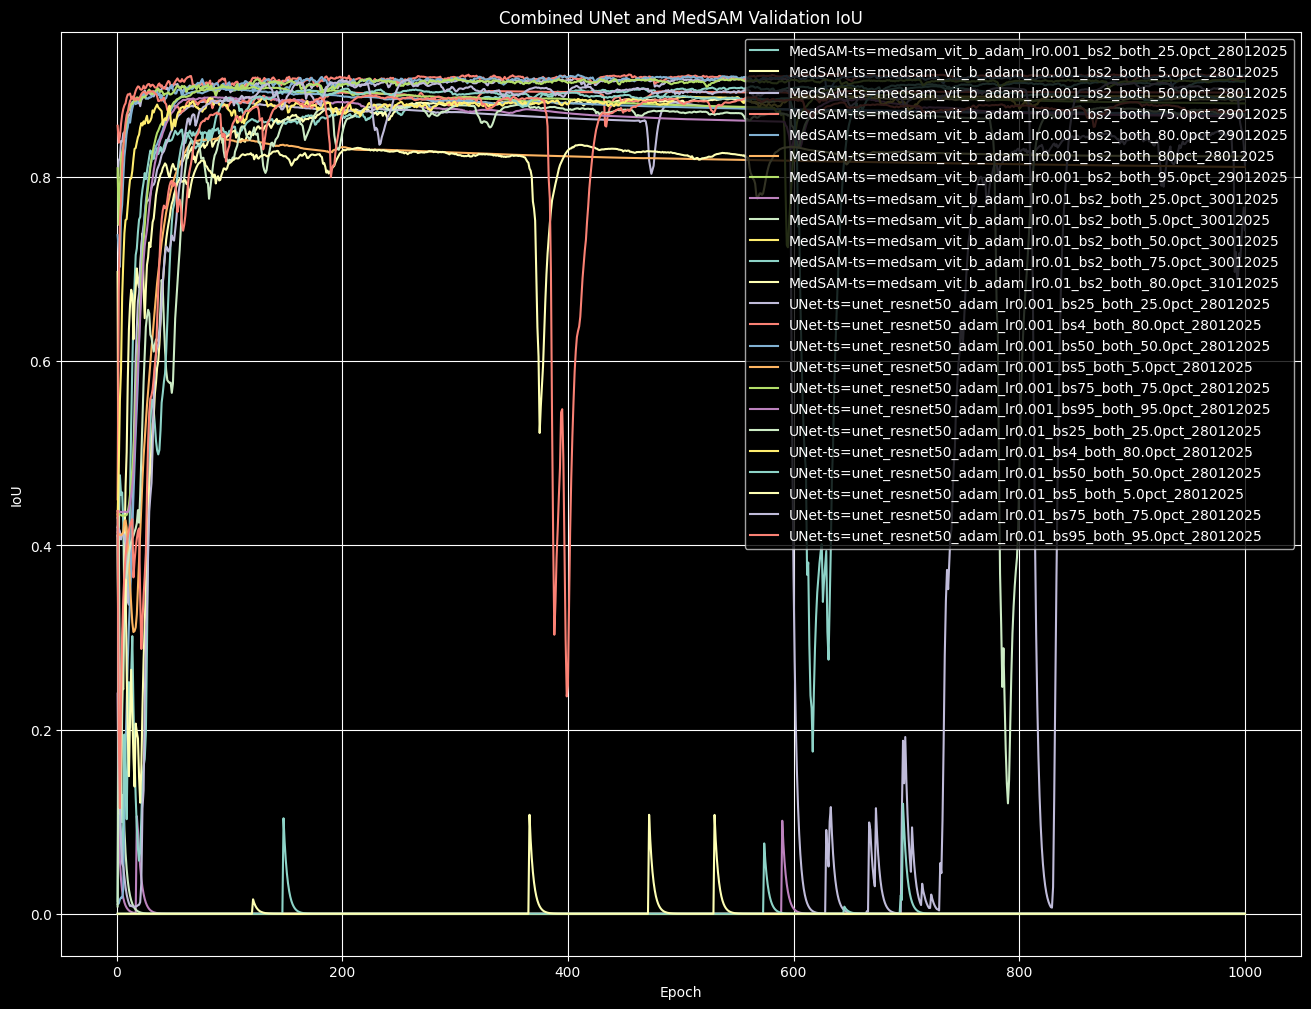

In [ ]:
combined_val_dice = {f"UNet-ts={ts}": values[2] for ts, values in unet_data.items()}
combined_val_dice.update({f"MedSAM-ts={ts}": values[2] for ts, values in medsam_data.items()})
plot_metric(combined_val_dice, "Combined UNet and MedSAM Validation dice", "dice", out_png=f"./metrics_overview/combined_val_dice{formatted_date}.png")